In the final part of this chapter we shall turn our attention to building a GAN where
we are able to control the output—a so called conditional GAN. This idea, first intro‐
duced in “Conditional Generative Adversarial Nets” by Mirza and Osindero in 2014,6
is a relatively simple extension to the GAN architecture.

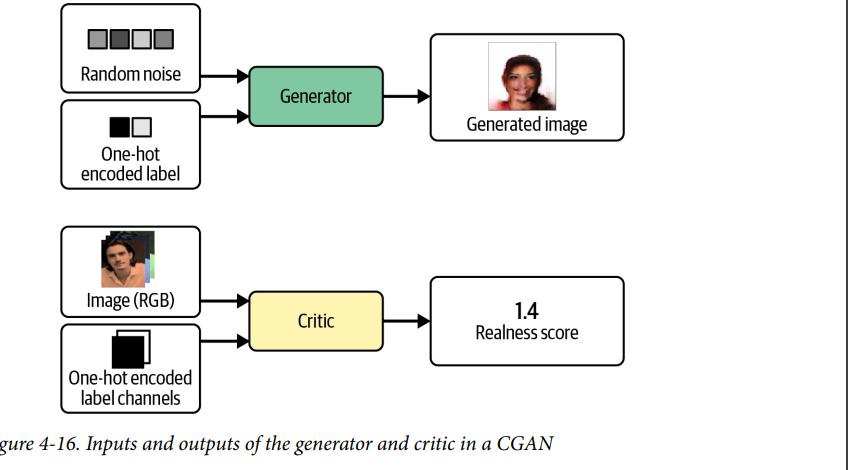

The key difference between a standard GAN and a CGAN is that in a CGAN we pass
in extra information to the generator and critic relating to the label. In the generator,
this is simply appended to the latent space sample as a one-hot encoded vector. In the
critic, we add the label information as extra channels to the RGB image. We do this
by repeating the one-hot encoded vector to fill the same shape as the input images

CGANs work because the critic now has access to extra information regarding the
content of the image, so the generator must ensure that its output agrees with the
provided label, in order to keep fooling the critic. If the generator produced perfectimages that disagreed with the image label the critic would be able to tell that they
were fake simply because the images and labels did not match.

In our example, our one-hot encoded label will have length 2,
because there are two classes (Blonde and Not Blond). However,
you can have as many labels as you like—for example, you could
train a CGAN on the Fashion-MNIST dataset to output one of the
10 different fashion items, by incorporating a one-hot encoded
label vector of length 10 into the input of the generator and 10
additional one-hot encoded label channels into the input of the
critic.

The only change we need to make to the architecture is to concatenate the label infor‐
mation to the existing inputs of the generator and the critic

In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    optimizers,
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
IMAGE_SIZE = 64
CHANNELS = 3
CLASSES = 2
BATCH_SIZE = 128
Z_DIM = 32
LEARNING_RATE = 0.00005
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
EPOCHS = 20
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
LABEL = "Blond_Hair"

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jayshah1234","key":"b5a70f58d9814ed536fb83b549b26d2c"}'}

In [ ]:
# Move the uploaded kaggle.json file to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Now you can use the Kaggle API to download the dataset
kaggle_username = "jessicali9530"
dataset_name = "celeba-dataset"

# Create the Kaggle dataset URL
dataset_url = f"{kaggle_username}/{dataset_name}"

# Download the dataset using Kaggle API
!kaggle datasets download -d $dataset_url

# Unzip the downloaded dataset
!unzip -q {dataset_name}.zip -d {dataset_name}

 99% 1.32G/1.33G [00:06<00:00, 209MB/s]
100% 1.33G/1.33G [00:06<00:00, 229MB/s]


In [ ]:
# Load the label dataset
attributes = pd.read_csv("/content/celeba-dataset/list_attr_celeba.csv")
print(attributes.columns)
attributes.head()

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [ ]:
# Load the data
labels = attributes[LABEL].tolist()
int_labels = [x if x == 1 else 0 for x in labels]

In [ ]:
train_data = utils.image_dataset_from_directory(
    "/content/celeba-dataset/img_align_celeba/img_align_celeba",
    labels=int_labels,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 202599 files belonging to 2 classes.


In [ ]:
# Preprocess the data
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = train_data.map(
    lambda x, y: (preprocess(x), tf.one_hot(y, depth=CLASSES))
)

In [ ]:
critic_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
label_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CLASSES))
x = layers.Concatenate(axis=-1)([critic_input, label_input])
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid")(x)
critic_output = layers.Flatten()(x)

critic = models.Model([critic_input, label_input], critic_output)
critic.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 64, 64, 2)]          0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 64, 64, 5)            0         ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           5184      ['concatenate[0][0]']     

In [ ]:
generator_input = layers.Input(shape=(Z_DIM,))
label_input = layers.Input(shape=(CLASSES,))
x = layers.Concatenate(axis=-1)([generator_input, label_input])
x = layers.Reshape((1, 1, Z_DIM + CLASSES))(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=4, strides=2, padding="same", activation="tanh"
)(x)
generator = models.Model([generator_input, label_input], generator_output)
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 concatenate_1 (Concatenate  (None, 34)                   0         ['input_3[0][0]',             
 )                                                                   'input_4[0][0]']             
                                                                                                  
 reshape (Reshape)           (None, 1, 1, 34)             0         ['concatenate_1[0][0]'] 

In [ ]:
class ConditionalWGAN(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(ConditionalWGAN, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(ConditionalWGAN, self).compile(run_eagerly=True)
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric,
        ]

    def gradient_penalty(
        self, batch_size, real_images, fake_images, image_one_hot_labels
    ):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(
                [interpolated, image_one_hot_labels], training=True
            )

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        real_images, one_hot_labels = data

        image_one_hot_labels = one_hot_labels[:, None, None, :]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=IMAGE_SIZE, axis=1
        )
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=IMAGE_SIZE, axis=2
        )

        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )

            with tf.GradientTape() as tape:
                fake_images = self.generator(
                    [random_latent_vectors, one_hot_labels], training=True
                )

                fake_predictions = self.critic(
                    [fake_images, image_one_hot_labels], training=True
                )
                real_predictions = self.critic(
                    [real_images, image_one_hot_labels], training=True
                )

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(
                    real_predictions
                )
                c_gp = self.gradient_penalty(
                    batch_size, real_images, fake_images, image_one_hot_labels
                )
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(
                zip(c_gradient, self.critic.trainable_variables)
            )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        with tf.GradientTape() as tape:
            fake_images = self.generator(
                [random_latent_vectors, one_hot_labels], training=True
            )
            fake_predictions = self.critic(
                [fake_images, image_one_hot_labels], training=True
            )
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}


In [ ]:
# Create a GAN
cgan = ConditionalWGAN(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [ ]:
# Compile the GAN
cgan.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [ ]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        # 0 label
        zero_label = np.repeat([[1, 0]], self.num_img, axis=0)
        generated_images = self.model.generator(
            [random_latent_vectors, zero_label]
        )
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()

        plt.figure(figsize=(10, 10))
        for i in range(self.num_img):
            img = utils.array_to_img(generated_images[i])
            plt.imshow(img)
            plt.axis('off')
            plt.title(f'Label: 0')

        plt.show()

        # 1 label
        one_label = np.repeat([[0, 1]], self.num_img, axis=0)
        generated_images = self.model.generator(
            [random_latent_vectors, one_label]
        )
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        for i in range(self.num_img):
            img = utils.array_to_img(generated_images[i])
            plt.imshow(img)
            plt.axis('off')
            plt.title(f'Label: 1')

        plt.show()

In [ ]:
history = cgan.fit(
    train,
    epochs=EPOCHS * 100,
    steps_per_epoch=1,
    callbacks=[
        model_checkpoint_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

We can control the CGAN output by passing a particular one-hot encoded label into
the input of the generator. For example, to generate a face with nonblond hair, we
pass in the vector [1, 0]. To generate a face with blond hair, we pass in the vector
[0, 1]

Here, we keep the random
latent vectors the same across the examples and change only the conditional label
vector. It is clear that the CGAN has learned to use the label vector to control only the
hair color attribute of the images. It is impressive that the rest of the image barely
changes—this is proof that GANs are able to organize points in the latent space in
such a way that individual features can be decoupled from each other.

In [ ]:
# 0 label
z_sample = np.random.normal(size=(10, Z_DIM))
class_label = np.repeat([[1, 0]], 10, axis=0)
imgs = cgan.generator.predict([z_sample, class_label])
display(imgs, cmap=None)

In [ ]:
# 1 label
z_sample = np.random.normal(size=(10, Z_DIM))
class_label = np.repeat([[0, 1]], 10, axis=0)
imgs = cgan.generator.predict([z_sample, class_label])
display(imgs, cmap=None)

If labels are available for your dataset, it is generally a good idea to
include them as input to your GAN even if you do not necessarily
need to condition the generated output on the label, as they tend to
improve the quality of images generated. You can think of the
labels as just a highly informative extension to the pixel input.